In [1]:
import glob
import os
import numpy as np
import subprocess
import sys

from astropy.io import fits
from astropy.wcs import WCS, utils
from astropy.coordinates import SkyCoord
from astropy import units as u

from photutils import SkyCircularAnnulus, SkyCircularAperture, aperture_photometry
from regions import CircleSkyRegion
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.visualization import PercentileInterval, ManualInterval, ImageNormalize, AsinhStretch, LogStretch, LinearStretch

import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.colors import LogNorm

In [2]:
sas_dir = "/home/aaranda/SAS/sas_18.0.0-Ubuntu16.04-64/xmmsas_20190531_1155"
os.environ["SAS_DIR"] = sas_dir
os.environ["SAS_PATH"] = os.environ["SAS_DIR"]
os.environ["SAS_VERBOSITY"] = "4"
os.environ["SAS_SUPPRESS_WARNING"] = "1"
path = os.environ["PATH"]
os.environ["PATH"] = f"{sas_dir}/bin:{sas_dir}/binextra:{path}"
if "LD_LIBRARY_PATH" in os.environ.keys():
    ld_path = os.environ["LD_LIBRARY_PATH"]
# lib_path = f"{sas_dir}/lib:{sas_dir}/libextra:{sas_dir}/libsys:{ld_path}"
lib_path = f"{sas_dir}/lib:{sas_dir}/libextra:{sas_dir}"
os.environ["LD_LIBRARY_PATH"] = lib_path
os.environ["PERL5LIB"] = "{}/lib/perl5".format(sas_dir)
os.environ['SAS_CCFPATH'] = "/home/aaranda/SAS/sas_18.0.0-Ubuntu16.04-64/xmmsas_20190531_1155/calibration"
!sasversion
!perl -e "print qq(@INC)"

sasversion:- Executing (routine): sasversion  -w 1 -V 4
sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] started:  2020-07-05T17:44:38.000
sasversion:- XMM-Newton SAS release and build information:

SAS release: xmmsas_20190531_1155-18.0.0
Compiled on: Sun Jun  2 14:11:18 CEST 2019
Compiled by: sasbuild@sasbld03n
Platform   : Ubuntu16.04 64

SAS-related environment variables that are set:

SAS_DIR = /home/aaranda/SAS/sas_18.0.0-Ubuntu16.04-64/xmmsas_20190531_1155
SAS_PATH = /home/aaranda/SAS/sas_18.0.0-Ubuntu16.04-64/xmmsas_20190531_1155
SAS_CCFPATH = /home/aaranda/SAS/sas_18.0.0-Ubuntu16.04-64/xmmsas_20190531_1155/calibration

sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] ended:    2020-07-05T17:44:38.000
/home/aaranda/SAS/sas_18.0.0-Ubuntu16.04-64/xmmsas_20190531_1155/lib/perl5 /etc/perl /usr/local/lib/x86_64-linux-gnu/perl/5.26.1 /usr/local/share/perl/5.26.1 /usr/lib/x86_64-linux-gnu/perl5/5.26 /usr/share/perl5 /usr/lib/x86_64-linux-g

In [3]:
def exec_task(task, verbose=True):
    try:
        # Write the shell output to tmp.log file.
        fout = open("tmp.log", "w")
        result = subprocess.run(task, shell=True, stdout=fout, stderr=subprocess.STDOUT)
        retcode = result.returncode
        fout.close()
        if retcode < 0:
            if (verbose):
                print(f"Execution of {task} was terminated by code {-retcode}.", file=sys.stderr)
        else:
            if (verbose):
                print(f"Execution of {task} returned {retcode}.", file=sys.stderr)
    except OSError as e:
        print(f"Execution of {task} failed:", e, file=sys.stderr)
    return retcode

In [4]:
def get_coords(odf_dir):
    logs_list = glob.glob("{}/logs/rad_prof*".format(odf_dir))
    aux = False
    aux_r = []
    circle = ""
    for log in logs_list:
        if not aux:
            with open(log, "r") as f:
                for line in f:
                    if "CIRCLE: " in line:
                        #circle = line.split(" ")[1]
                        circle = line.split("- ")[1].split(" ")[1]
                        #print(circle)
                if circle != "":
                    aux_r.append(float(circle.split(',')[2]))
                    #aux = True
    RA = float(circle.split(',')[0])
    DEC = float(circle.split(',')[1])
    r = max(aux_r)
    print(RA, DEC, r)
    return [RA, DEC, r]

In [5]:
def psf_gen(center, energy, box, psf_out):
    psfgen = f'psfgen image={fits_image} withimage=yes instrument=PN level=ELLBETA energy={energy} ' + \
             f'x={center.ra.value} y={center.dec.value} coordtype=EQPOS xsize={box} ysize={box} output={psf_out}'
    status = exec_task(psfgen)

In [6]:
def calc_radial_profile(fitsfile, center, rstart, rend, rstep, verbose=False, detmaskfile=None, plot=True):
    """

    Utility function to calculate the radial profile from an image `fitsfile` at a `center`

    """
    #
    if (not os.path.isfile(fitsfile)):
        print(f"ERROR. FITS file {fitsfile} not found. Cannot continue.")
        return None
    #
    qhdu = fits.open(fitsfile)
    wcs = WCS(qhdu[0].header)
    #
    # if detmaskfile is provided then will use it for detector mask
    #
    doMask = False
    if (detmaskfile != None):
        if (not os.path.isfile(detmaskfile)):
            print(f"Warning. Detector mask file {detmaskfile} not found. Will not use detector mask!")
            doMask = False
        else:
            det = fits.open(detmaskfile)
            detmask = det['MASK']
            # need the WCS
            wcs_det = WCS(detmask.header)
            doMask = True
    #
    if (not isinstance(center, SkyCoord)):
        print(f"EROOR: the input radial profile centre is not SkyCoord object. Cannot continue.")
        return None
    #
    j = 0
    rx = rstart
    counts = []
    counts_err = []
    rmid = []
    #
    while rx < r_end:
        r0 = rstart + rstep * j
        rx = rstart + rstep * (j + 1)
        # the mid point, can be better the mid area point
        rmid.append((r0.value + rx.value) / 2.0)
        if (j == 0):
            xap = SkyCircularAperture(center, rx)
            photo = aperture_photometry(qhdu[0].data, xap, wcs=wcs)
            if (doMask):
                masked = aperture_photometry(detmask.data, xap, wcs=wcs_det)
        else:
            xap = SkyCircularAnnulus(center, r0, rx)
            photo = aperture_photometry(qhdu[0].data, xap, wcs=wcs)
            if (doMask):
                masked = aperture_photometry(detmask.data, xap, wcs=wcs_det)
        #
        ap_area = xap.to_pixel(wcs).area
        good_area = ap_area
        if (doMask):
            good_area = masked['aperture_sum'][0]
        # compare the two annuli areas: with and without bad pixels
        if (verbose):
            print(
                f"Annulus: {r0:.2f},{rx:.2f},geometric area: {ap_area:.1f} pixels,non-masked area {good_area:.1f} pixels, ratio: {ap_area / good_area:.2f}")
        # taking into account the masked pixels
        counts.append(photo['aperture_sum'][0] / good_area)
        counts_err.append(np.sqrt(photo['aperture_sum'][0]) / good_area)
        j += 1
    #
    # convert the results in numpy arrays
    #
    rmid = np.array(rmid)
    counts = np.array(counts)
    counts_err = np.array(counts_err)
    #
    # convert per pixel to per arcsec^2
    pix_area = utils.proj_plane_pixel_area(wcs) * 3600.0 * 3600.0  # in arcsec^2
    counts = counts / pix_area
    counts_err = counts_err / pix_area
    #

    qhdu.close()
    if (doMask):
        det.close()
    return rmid, counts, counts_err

In [7]:
def calc_radial_profile_v2(fitsfile, center, rstart, rend, rstep, verbose=False, detmaskfile=None, plot=True):
    """

    Utility function to calculate the radial profile from an image `fitsfile` at a `center`

    """
    #
    if (not os.path.isfile(fitsfile)):
        print(f"ERROR. FITS file {fitsfile} not found. Cannot continue.")
        return None
    #
    qhdu = fits.open(fitsfile)
    wcs = WCS(qhdu[0].header)
    #
    # if detmaskfile is provided then will use it for detector mask
    #
    doMask = False
    if (detmaskfile != None):
        if (not os.path.isfile(detmaskfile)):
            print(f"Warning. Detector mask file {detmaskfile} not found. Will not use detector mask!")
            doMask = False
        else:
            det = fits.open(detmaskfile)
            detmask = det['MASK']
            # need the WCS
            wcs_det = WCS(detmask.header)
            doMask = True
    #
    if (not isinstance(center, SkyCoord)):
        print(f"EROOR: the input radial profile centre is not SkyCoord object. Cannot continue.")
        return None
    #
    j = 0
    rx = rstart
    counts = []
    counts_err = []
    rmid = []
    #
    emtpy = False
    while rx < r_end:
        r0 = rstart + rstep * j
        rx = rstart + rstep * (j + 1)
        # the mid point, can be better the mid area point
        rmid.append((r0.value + rx.value) / 2.0)
        if (j == 0):
            xap = SkyCircularAperture(center, rx)
            photo = aperture_photometry(qhdu[0].data, xap, wcs=wcs)
            if (doMask):
                masked = aperture_photometry(detmask.data, xap, wcs=wcs_det)
        else:
            xap = SkyCircularAnnulus(center, r0, rx)
            photo = aperture_photometry(qhdu[0].data, xap, wcs=wcs)
            if (doMask):
                masked = aperture_photometry(detmask.data, xap, wcs=wcs_det)
        #
        ap_area = xap.to_pixel(wcs).area
        good_area = ap_area
        if (doMask):
            good_area = masked['aperture_sum'][0]
        # compare the two annuli areas: with and without bad pixels
        if (verbose):
            print(
                f"Annulus: {r0:.2f},{rx:.2f},geometric area: {ap_area:.1f} pixels,non-masked area {good_area:.1f} pixels, ratio: {ap_area / good_area:.2f}")
        # taking into account the masked pixels
        if (good_area == 0.0):
            counts.append(float('nan'))
            counts_err.append(float('nan'))
        else:
            counts.append(photo['aperture_sum'][0] / good_area)
            counts_err.append(np.sqrt(photo['aperture_sum'][0]) / good_area)

        j += 1
    #
    # convert the results in numpy arrays
    #
    rmid = np.array(rmid)
    counts = np.array(counts)
    counts_err = np.array(counts_err)
    #
    # convert per pixel to per arcsec^2
    pix_area = utils.proj_plane_pixel_area(wcs) * 3600.0 * 3600.0  # in arcsec^2
    counts = counts / pix_area
    counts_err = counts_err / pix_area
    #
    if (plot):
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.errorbar(rmid, counts, xerr=rstep.value / 2.0, yerr=counts_err)
        ax.set_xscale('linear')
        ax.set_yscale('log')
        ax.set_xlabel('Radial distance (arcsec)')
        ax.set_ylabel(r'Counts/arcsec$^2$')
        ax.grid()
        ax.set_title(f"Radial profile");
    qhdu.close()
    if (doMask):
        det.close()
    return rmid, counts, counts_err

In [292]:
wdir = "/home/aaranda/tfm/obsid"
bll_catalog = fits.open('/home/aaranda/tfm/bllacs_PN_NopileupNofasttiming.fits')
data = bll_catalog[1].data

obsid = '0761100301'


for row in data:
    if row[5] == obsid:
        target = row[0]


odf_dir = "{}/{}".format(wdir, obsid)

os.chdir(odf_dir)

cif_file = "{}/ccf.cif".format(odf_dir)
os.environ['SAS_CCF'] = cif_file
SUM_SAS_file = glob.glob("*SUM.SAS")[0]
os.environ['SAS_ODF'] = SUM_SAS_file

In [355]:
expr = 'PI in [4500:10000] &&  FLAG==0 && PATTERN in [0:4]'
task = f'evselect table=pn_qpb_clean.fits expression=\'{expr}\' ' \
    'imagebinning=binSize imageset=pn_qpb_image_high.fits withimageset=yes ' \
    'xcolumn=X ycolumn=Y ximagebinsize=80 yimagebinsize=80'   
status = exec_task(task)


os.environ["LD_LIBRARY_PATH"] = "/home/aaranda/heasoft-6.26.1ubuntu_1804/heasoft-6.26.1/x86_64-pc-linux-gnu-libc2.27/lib"
sci_image = f'{odf_dir}/images/image_filtered_high.fits'
sci_corr_image = 'pn_sci_corr_image_high.fits'
if os.path.isfile(sci_corr_image):
    os.remove(sci_corr_image)
task = f'farith images/image_filtered_high.fits pn_qpb_image_high.fits {sci_corr_image} SUB'
status = exec_task(task)

os.environ["LD_LIBRARY_PATH"] = lib_path

Execution of evselect table=pn_qpb_clean.fits expression='PI in [4500:10000] &&  FLAG==0 && PATTERN in [0:4]' imagebinning=binSize imageset=pn_qpb_image_high.fits withimageset=yes xcolumn=X ycolumn=Y ximagebinsize=80 yimagebinsize=80 returned 0.
Execution of farith images/image_filtered_high.fits pn_qpb_image_high.fits pn_sci_corr_image_high.fits SUB returned 0.


238.9296 11.19 0.03333333333333333


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


3.999999999999996
346.9813305571201 330.9292763866013
63


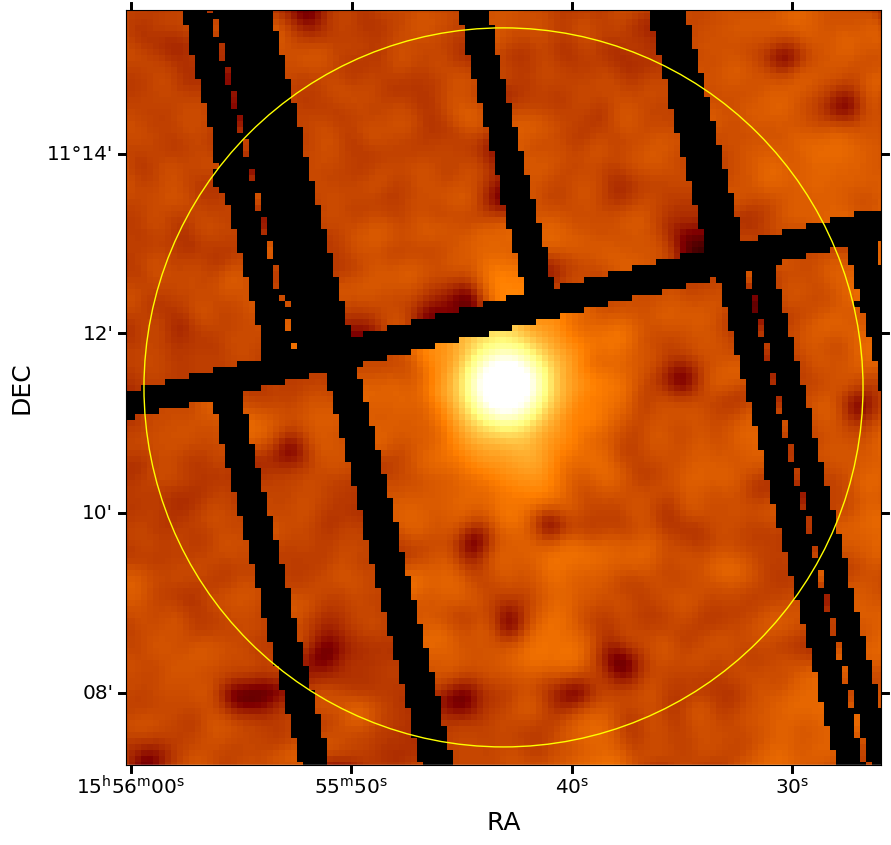

In [293]:
coords = get_coords(odf_dir)
center = SkyCoord(coords[0], coords[1], unit=(u.deg, u.deg), frame='icrs')
r_start = 0.0 * u.arcsec
r_end = 4.0 * u.arcmin
r_step = 6.0 * u.arcsec

detmask_file = '{}/detfile_low.fits'.format(odf_dir)
det = fits.open(detmask_file)
detmask = det['MASK']
wcs_det = WCS(detmask.header)
fits_image = '{}/images/image_filtered_high.fits'.format(odf_dir)
#fits_image = '{}/pn_sci_corr_image_high.fits'.format(odf_dir)
hdu = fits.open(fits_image)
wcs = WCS(hdu[0].header)
g2_kernel = Gaussian2DKernel(2)
smoothed_data_g2 = convolve(hdu[0].data, g2_kernel, mask=np.logical_not(detmask.data)) * detmask.data


fig = plt.figure(figsize=(10, 10), dpi=100)
pp = 99.9  # colour cut percentage

ax = fig.add_subplot(111, projection=wcs)
#ax.set_title("Gaussian smoothed image")

from astropy.visualization import MinMaxInterval

#norm_xmm = ImageNormalize(smoothed_data_g2, interval=MinMaxInterval(), stretch=LogStretch())

norm_xmm = ImageNormalize(smoothed_data_g2, interval=ManualInterval(vmin=0.01, vmax=100.0), stretch=LogStretch())

#norm_xmm = ImageNormalize(smoothed_data_g2,interval=PercentileInterval(pp), stretch=AsinhStretch())
ax.imshow(smoothed_data_g2, cmap=plt.cm.afmhot, norm=norm_xmm, origin='lower', interpolation='nearest')
ax.xlabel = 'RA'
ax.ylabel = 'Dec'
ax.set_xlabel('RA', fontsize=18)
ax.set_ylabel('DEC', fontsize=18)

pix_area = utils.proj_plane_pixel_area(wcs)
print(np.sqrt(pix_area) * 3600)

py, px = wcs.wcs_world2pix(coords[0], coords[1], 1)
print('{0} {1}'.format(px, py))

rad = 4.2 * 60
pixels = int(rad / 4)
print(pixels)

x_inf = int(px)-pixels
x_sup = int(px)+pixels
y_inf = int(py)-pixels
y_sup = int(py)+pixels

ax.set_ylim(x_inf, x_sup)
ax.set_xlim(y_inf, y_sup)

ax.tick_params(direction='out', labelsize='x-large', length=6, width=2, grid_alpha=0.5)

#
# only show the last aperture
#
circle_sky = CircleSkyRegion(center=center, radius=r_end)
pix_reg = circle_sky.to_pixel(wcs)
pix_reg.plot(ax=ax, edgecolor='yellow')

path='/home/aaranda/tfm/thesis_results/{}'.format(obsid)
if not os.path.isdir(path):
    os.mkdir(path)
if os.path.isfile('{}/smoothed_g2_image_high.png'.format(path)):
    os.remove('{}/smoothed_g2_image_high.png'.format(path))
plt.savefig('{}/smoothed_g2_image_high.png'.format(path))
#plt.close(fig)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Execution of psfgen image=/home/aaranda/tfm/obsid/0761100301/images/image_filtered_high.fits withimage=yes instrument=PN level=ELLBETA energy=1000 x=238.9296 y=11.19 coordtype=EQPOS xsize=481 ysize=481 output=/home/aaranda/tfm/obsid/0761100301/psf_ellbeta_1000_481pix.fits returned 0.


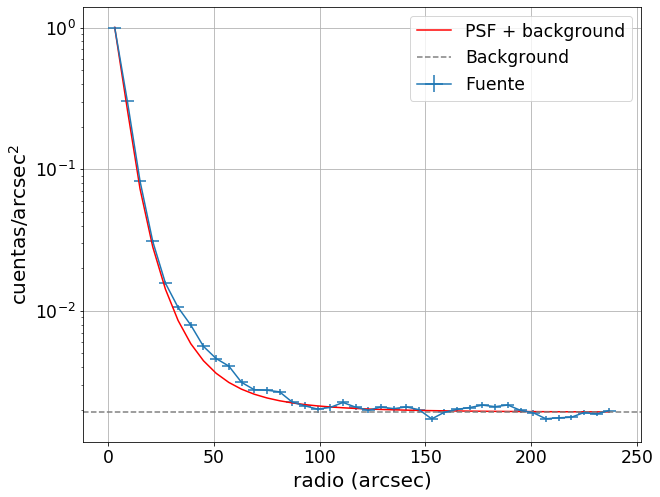

In [294]:
(x, y, yerr) = calc_radial_profile(fits_image, center, r_start, r_end, r_step, verbose=False,
                                   detmaskfile=detmask_file, plot=False)

energy = 1000  # at 1 keV
box = 2 * int(r_end.to(u.arcsec).value) + 1
psf_out = '{}/psf_ellbeta_{}_{}pix.fits'.format(odf_dir, energy, box)
psf_gen(center, energy, box, psf_out)


(psf_mid, psf_counts, psf_counts_err) = \
    calc_radial_profile(psf_out, center, r_start, r_end, r_step, verbose=False, detmaskfile=None, plot=False)

normalization = 0

norm_counts = y / y[normalization]
norm_counts_err = yerr / y[normalization]
back = np.mean(norm_counts[-3:])  # the mean of the last 3 radial points

#
# and normalise the PSF
#
norm_psf_counts = psf_counts / psf_counts[normalization]

fig, ax = plt.subplots(figsize=(10, 8))
ax.errorbar(x, norm_counts, xerr=r_step.value / 2.0, yerr=norm_counts_err, label='Fuente')
ax.plot(psf_mid, norm_psf_counts + back, label='PSF + background', color='red')
ax.axhline(back, color='gray', linestyle="--", label='Background')
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlabel('radio (arcsec)', fontsize=20)
ax.set_ylabel(r'cuentas/arcsec$^2$',fontsize=20)
ax.tick_params(labelsize='xx-large')
ax.grid()
ax.legend(fontsize='xx-large')
plt.savefig('{}/radial_profile_high.png'.format(path))